# Classification of Nigerian Traditional Attire

This project classifies images of Nigerian ethnic groups using transfer learning with convolutional neural networks. We experiment with ResNet18, ResNet34, and EfficientNet to compare performance.


### Downloading Data from Google Drive

In [ ]:
!pip install -q gdown
import gdown

# Google Drive file ID
file_id = "12sFm2jiuA5zwIWZWc-teWnniKYkEJzqX"
output = "data_split.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=12sFm2jiuA5zwIWZWc-teWnniKYkEJzqX
From (redirected): https://drive.google.com/uc?id=12sFm2jiuA5zwIWZWc-teWnniKYkEJzqX&confirm=t&uuid=da578c8d-632d-4bd1-bf8c-175863751258
To: /content/data_split.zip
100%|██████████| 148M/148M [00:00<00:00, 221MB/s]


'data_split.zip'

### Unzipping the file

In [ ]:
import zipfile

with zipfile.ZipFile("data_split.zip", 'r') as zip_ref:
    zip_ref.extractall()


### Importing Libraries

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


### Data Preparation

In [ ]:
import os
import shutil
import random

def split_dataset(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    # Create destination folders
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dest_dir, split)
        os.makedirs(split_path, exist_ok=True)

    # Process each class folder
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        train_cutoff = int(train_ratio * len(images))
        val_cutoff = int((train_ratio + val_ratio) * len(images))

        split_sets = {
            'train': images[:train_cutoff],
            'val': images[train_cutoff:val_cutoff],
            'test': images[val_cutoff:]
        }

        for split, split_images in split_sets.items():
            split_dir = os.path.join(dest_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

    print("✅ Dataset split complete.")

# Usage
split_dataset('nigerian_attire', 'data_split', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


✅ Dataset split complete.


### Data Transforms and Loaders

In [ ]:
import os
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets

# ✅ Set seed for everything
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# ✅ Define generator for reproducible DataLoader shuffling
g = torch.Generator()
g.manual_seed(42)

# ✅ Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Has randomness
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# ✅ Load datasets
data_dir = 'data_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

# ✅ Prepare WeightedRandomSampler for class balancing in training
train_targets = [label for _, label in image_datasets['train'].imgs]
class_counts = torch.tensor([train_targets.count(i) for i in range(len(set(train_targets)))], dtype=torch.float)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# ✅ Create DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, sampler=sampler,
                        num_workers=0, worker_init_fn=lambda _: set_seed(42), generator=g),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False,
                      num_workers=0, worker_init_fn=lambda _: set_seed(42), generator=g),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False,
                       num_workers=0, worker_init_fn=lambda _: set_seed(42), generator=g),
}

# ✅ Class names and device
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Model Definition (Pretrained EfficientNet)

#### Install EfficientNet

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.7 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=4e5206fa6529de989a5af91101378478cba19e14fbc51bdd

In [ ]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet-B0
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the classifier for your number of classes
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)


Loaded pretrained weights for efficientnet-b0


### Loss, Optimizer, and Class Weights

In [ ]:
# class weights to handle imbalance
class_counts = torch.tensor([len([label for _, label in image_datasets['train'] if label == i]) for i in range(len(class_names))])
class_weights = 1. / class_counts.float()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Training Loop

In [ ]:
import matplotlib.pyplot as plt

# Initialize logs
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10
patience = 5
best_accuracy = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(dataloaders['train'])
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_running_loss / len(dataloaders['val'])
    accuracy = 100 * correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve == patience:
    #         print("Early stopping!")
    #         break

    lr_scheduler.step()


Epoch 1/10, Train Loss: 0.8280, Val Loss: 1.0119, Val Accuracy: 65.13%
Epoch 2/10, Train Loss: 0.4958, Val Loss: 0.5709, Val Accuracy: 80.59%
Epoch 3/10, Train Loss: 0.3941, Val Loss: 0.3294, Val Accuracy: 87.83%
Epoch 4/10, Train Loss: 0.2713, Val Loss: 0.3834, Val Accuracy: 87.17%
Epoch 5/10, Train Loss: 0.2083, Val Loss: 0.3402, Val Accuracy: 86.84%
Epoch 6/10, Train Loss: 0.1859, Val Loss: 0.1972, Val Accuracy: 93.09%
Epoch 7/10, Train Loss: 0.1113, Val Loss: 0.0991, Val Accuracy: 96.05%
Epoch 8/10, Train Loss: 0.1271, Val Loss: 0.0743, Val Accuracy: 96.71%
Epoch 9/10, Train Loss: 0.0813, Val Loss: 0.0688, Val Accuracy: 96.71%
Epoch 10/10, Train Loss: 0.0787, Val Loss: 0.0580, Val Accuracy: 97.04%


### Plotting Accuracy and Loss

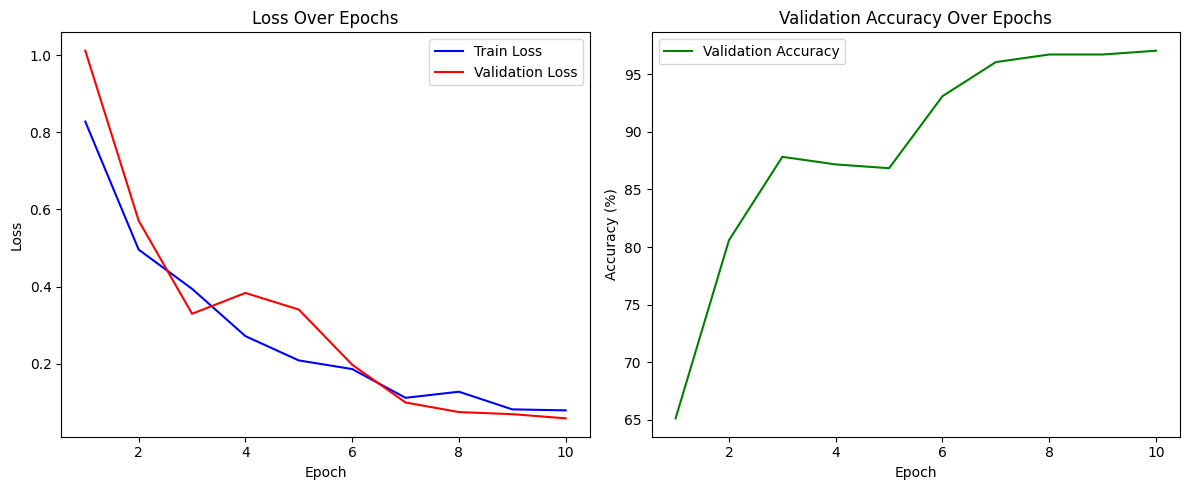

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


### Test the Model

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 97.70%


### Confusion Matrix and Classification Report

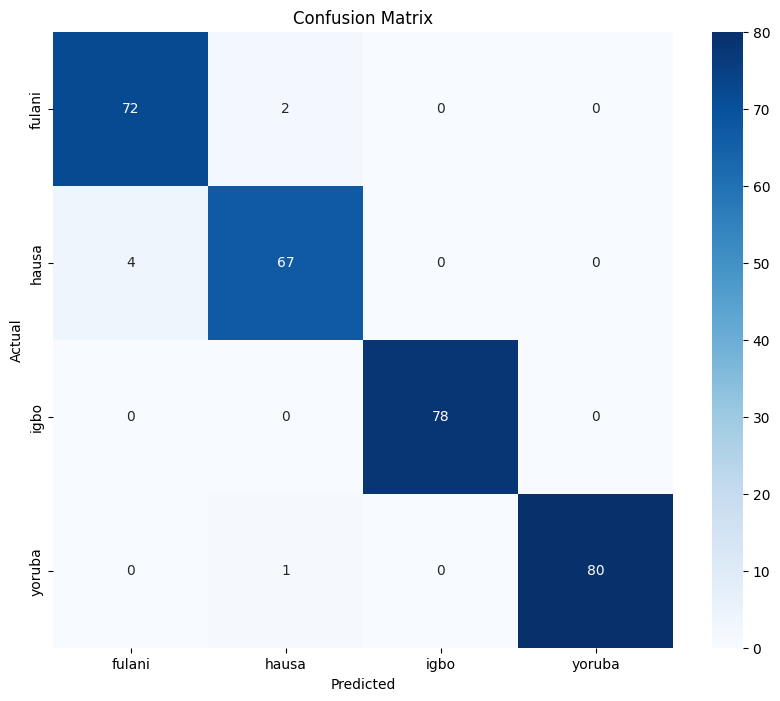

              precision    recall  f1-score   support

      fulani       0.95      0.97      0.96        74
       hausa       0.96      0.94      0.95        71
        igbo       1.00      1.00      1.00        78
      yoruba       1.00      0.99      0.99        81

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))


### Saving the Model

In [ ]:
# Saving (more portable way)
torch.save(model.state_dict(), 'efficientnetb0_weights.pth')



### Loadiing the Model

In [ ]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch

# Recreate model architecture
model = efficientnet_b0(weights=None)  # no warning
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

# Load the weights
state_dict = torch.load('efficientnetb0_weights.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Putting model to device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Deploying Model Using Gradio

#### Installing gradio on colab

In [ ]:
!pip install gradio --quiet


#### Defining the prediction function

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

def predict_image(img):
    # Preprocess
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img = transform(img).unsqueeze(0).to(device)  # Add batch dim and move to device

    with torch.no_grad():
        outputs = model(img)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_prob, pred_index = torch.max(probs, 1)

    predicted_class = class_names[pred_index.item()]
    confidence = top_prob.item()
    return f"{predicted_class} ({confidence:.2%} confidence)"


#### Building and launching the Gradio app

In [ ]:
import gradio as gr

gr.Interface(fn=predict_image,
             inputs=gr.Image(type="pil"),
             outputs="text",
             title="Nigerian Attire Classifier",
             description="Upload an image of Nigerian attire to classify it as Fulani, Hausa, Igbo, or Yoruba."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1fe70461f6e1a7a256.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Lunching the Deployment Server Locally Using Gradio App

In [ ]:
!python ethnic_classifier_gradio_app.py

python3: can't open file '/content/ethnic_classifier_gradio_app.py': [Errno 2] No such file or directory
